In [2]:
import os, glob, time, datetime
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

import torch
import torch.nn as nn
from torchvision.utils import save_image

from common.dataset import TrainDataProvider
from common.function import init_embedding
from common.models import Encoder, Decoder, Discriminator, Generator
from common.utils import denorm_image

### GPU Option

In [2]:
GPU = torch.cuda.is_available()
GPU

True

### Path Setting

In [3]:
data_dir = './dataset/'
model_dir = './model_save/'
fixed_dir = './fixed_sample'

### Get Fixed sample

In [4]:
fixed_sources, fixed_targets, fixed_labels = [], [], []

# font별 fixed target
for i in range(25):
    source = torch.load(os.path.join(fixed_dir, 'fixed_source_%d.pkl' % i))
    target = torch.load(os.path.join(fixed_dir, 'fixed_target_%d.pkl' % i))
    label = torch.load(os.path.join(fixed_dir, 'fixed_label_%d.pkl' % i))
    fixed_sources.append(source)
    fixed_targets.append(target)
    fixed_labels.append(label)
    
# 모든 폰트가 섞여있는 target
source = torch.load(os.path.join(fixed_dir, 'fixed_source_all.pkl'))
target = torch.load(os.path.join(fixed_dir, 'fixed_target_all.pkl'))
label = torch.load(os.path.join(fixed_dir, 'fixed_label_all.pkl'))
fixed_sources.append(source)
fixed_targets.append(target)
fixed_labels.append(label)

print("fixed sources:", len(fixed_sources))
print("fixed targets:", len(fixed_targets))
print("fixed labels:", len(fixed_labels))

fixed sources: 26
fixed targets: 26
fixed labels: 26


### fixed_source는 일단 폰트 다 섞여있는 걸로 지정

In [5]:
fixed_source = fixed_sources[-1]
fixed_target = fixed_targets[-1]
fixed_label = fixed_labels[-1]

### Get Fixed Embedding

In [6]:
embeddings = torch.load(os.path.join(fixed_dir, 'EMBEDDINGS.pkl'))
embeddings.shape

torch.Size([100, 1, 1, 128])

### Hyper Parameter Setting

In [7]:
FONTS_NUM = 25
EMBEDDING_NUM = 100
BATCH_SIZE = 32
IMG_SIZE = 128
EMBEDDING_DIM = 128

### Data Provider

In [8]:
data_provider = TrainDataProvider(data_dir)
total_batches = data_provider.compute_total_batch_num(BATCH_SIZE)
print("total batches:", total_batches)

unpickled total 181619 examples
unpickled total 45040 examples
train examples -> 181619, val examples -> 45040
total batches: 5676


In [9]:
def train(max_epoch, schedule, data_dir, save_path, to_model_path, lr=0.001, \
          log_step=100, sample_step=350, fine_tune=False, flip_labels=False, \
          restore=None, from_model_path=False, GPU=True):
    
    # Fine Tuning coefficient
    if not fine_tune:
        L1_penalty, Lconst_penalty = 100, 15
    else:
        L1_penalty, Lconst_penalty = 500, 1000

    # Get Models
    En = Encoder()
    De = Decoder()
    D = Discriminator(category_num=FONTS_NUM)
    if GPU:
        En.cuda()
        De.cuda()
        D.cuda()
    
    # Use pre-trained Model
    # restore에 [encoder_path, decoder_path, discriminator_path] 형태로 인자 넣기
    if restore:
        encoder_path, decoder_path, discriminator_path = restore
        prev_epoch = int(encoder_path.split('-')[0])
        En.load_state_dict(torch.load(os.path.join(from_model_path, encoder_path)))
        De.load_state_dict(torch.load(os.path.join(from_model_path, decoder_path)))
        D.load_state_dict(torch.load(os.path.join(from_model_path, discriminator_path)))
        print("%d epoch trained model has restored" % prev_epoch)
    else:
        prev_epoch = 0
        print("New model training start")

        
    # L1 loss, binary real/fake loss, category loss, constant loss
    if GPU:
        l1_criterion = nn.L1Loss(size_average=True).cuda()
        bce_criterion = nn.BCEWithLogitsLoss(size_average=True).cuda()
        mse_criterion = nn.MSELoss(size_average=True).cuda()
    else:
        l1_criterion = nn.L1Loss(size_average=True)
        bce_criterion = nn.BCEWithLogitsLoss(size_average=True)
        mse_criterion = nn.MSELoss(size_average=True)


    # optimizer
    G_parameters = list(En.parameters()) + list(De.parameters())
    g_optimizer = torch.optim.Adam(G_parameters, betas=(0.5, 0.999))
    d_optimizer = torch.optim.Adam(D.parameters(), betas=(0.5, 0.999))
    
    # losses lists
    l1_losses, const_losses, category_losses, d_losses, g_losses = list(), list(), list(), list(), list()
    
    # training
    count = 0
    for epoch in range(max_epoch):
        if (epoch + 1) % schedule == 0:
            updated_lr = max(lr/2, 0.0002)
            for param_group in d_optimizer.param_groups:
                param_group['lr'] = updated_lr
            for param_group in g_optimizer.param_groups:
                param_group['lr'] = updated_lr
            if lr !=  updated_lr:
                print("decay learning rate from %.5f to %.5f" % (lr, updated_lr))
            lr = updated_lr
            
        train_batch_iter = data_provider.get_train_iter(BATCH_SIZE)   
        for i, batch in enumerate(train_batch_iter):
            labels, batch_images = batch
            embedding_ids = labels
            if GPU:
                batch_images = batch_images.cuda()
            if flip_labels:
                np.random.shuffle(embedding_ids)
                
            # target / source images
            real_target = batch_images[:, 0, :, :].view([BATCH_SIZE, 1, IMG_SIZE, IMG_SIZE])
            real_source = batch_images[:, 1, :, :].view([BATCH_SIZE, 1, IMG_SIZE, IMG_SIZE])
            
            # generate fake image form source image
            fake_target, encoded_source = Generator(real_source, En, De, embeddings, embedding_ids, GPU=GPU)
            
            real_TS = torch.cat([real_source, real_target], dim=1)
            fake_TS = torch.cat([real_source, fake_target], dim=1)
            
            # Scoring with Discriminator
            real_score, real_score_logit, real_cat_logit = D(real_TS)
            fake_score, fake_score_logit, fake_cat_logit = D(fake_TS)
            
            # Get encoded fake image to calculate constant loss
            encoded_fake = En(fake_target)[0]
            const_loss = Lconst_penalty * mse_criterion(encoded_source, encoded_fake)
            
            # category loss
            real_category = torch.from_numpy(np.eye(FONTS_NUM)[embedding_ids]).float()
            if GPU:
                real_category = real_category.cuda()
            real_category_loss = bce_criterion(real_cat_logit, real_category)
            fake_category_loss = bce_criterion(fake_cat_logit, real_category)
            category_loss = 0.5 * (real_category_loss + fake_category_loss)
            
            # labels
            if GPU:
                one_labels = torch.ones([BATCH_SIZE, 1]).cuda()
                zero_labels = torch.zeros([BATCH_SIZE, 1]).cuda()
            else:
                one_labels = torch.ones([BATCH_SIZE, 1])
                zero_labels = torch.zeros([BATCH_SIZE, 1])
            
            # binary loss - T/F
            real_binary_loss = bce_criterion(real_score_logit, one_labels)
            fake_binary_loss = bce_criterion(fake_score_logit, zero_labels)
            binary_loss = real_binary_loss + fake_binary_loss
            
            # L1 loss between real and fake images
            l1_loss = L1_penalty * l1_criterion(real_target, fake_target)
            
            # cheat loss for generator to fool discriminator
            cheat_loss = bce_criterion(fake_score_logit, one_labels)
            
            # g_loss, d_loss
            g_loss = cheat_loss + l1_loss + fake_category_loss + const_loss
            d_loss = binary_loss + category_loss
            
            # train Discriminator
            D.zero_grad()
            d_loss.backward(retain_graph=True)
            d_optimizer.step()
            
            # train Generator
            En.zero_grad()
            De.zero_grad()
            g_loss.backward(retain_graph=True)
            g_optimizer.step()            
            
            # loss data
            l1_losses.append(l1_loss.data)
            const_losses.append(const_loss.data)
            category_losses.append(category_loss.data)
            d_losses.append(d_loss.data)
            g_losses.append(g_loss.data)
            
            # logging
            if (i+1) % log_step == 0:
                time_ = time.time()
                time_stamp = datetime.datetime.fromtimestamp(time_).strftime('%H:%M:%S')
                log_format = 'Epoch [%d/%d], step [%d/%d], l1_loss: %.4f, d_loss: %.4f, g_loss: %.4f' % \
                             (int(prev_epoch)+epoch+1, int(prev_epoch)+max_epoch, i+1, total_batches, \
                              l1_loss.item(), d_loss.item(), g_loss.item())
                print(time_stamp, log_format)
                
            # save image
            if (i+1) % sample_step == 0:
                fixed_fake_images = Generator(fixed_source, En, De, embeddings, fixed_label, GPU=GPU)[0]
                save_image(denorm_image(fixed_fake_images.data), \
                           os.path.join(save_path, 'fake_samples-%d-%d.png' % (int(prev_epoch)+epoch+1, i+1)), \
                           nrow=8)
        
        if (epoch+1) % 10 == 0:
            now = datetime.datetime.now()
            now_date = now.strftime("%m%d")
            now_time = now.strftime('%H:%M')
            torch.save(En.state_dict(), os.path.join(to_model_path, '%d-%s-%s-Encoder.pkl' \
                                                     % (int(prev_epoch)+epoch+1, now_date, now_time)))
            torch.save(De.state_dict(), os.path.join(to_model_path, '%d-%s-%s-Decoder.pkl' % \
                                                     (int(prev_epoch)+epoch+1, now_date, now_time)))
            torch.save(D.state_dict(), os.path.join(to_model_path, '%d-%s-%s-Discriminator.pkl' % \
                                                    (int(prev_epoch)+epoch+1, now_date, now_time)))

    # save model
    total_epoch = int(prev_epoch) + int(max_epoch)
    end = datetime.datetime.now()
    end_date = end.strftime("%m%d")
    end_time = end.strftime('%H:%M')
    torch.save(En.state_dict(), os.path.join(to_model_path, \
                                             '%d-%s-%s-Encoder.pkl' % (total_epoch, end_date, end_time)))
    torch.save(De.state_dict(), os.path.join(to_model_path, \
                                             '%d-%s-%s-Decoder.pkl' % (total_epoch, end_date, end_time)))
    torch.save(D.state_dict(), os.path.join(to_model_path, \
                                            '%d-%s-%s-Discriminator.pkl' % (total_epoch, end_date, end_time)))
    losses = [l1_losses, const_losses, category_losses, d_losses, g_losses]
    torch.save(losses, os.path.join(to_model_path, '%d-losses.pkl' % max_epoch))

    return l1_losses, const_losses, category_losses, d_losses, g_losses

### 25 Epoch에 이어 5 Epoch 더 해보기 (총 30Epoch)

- 25 epoch 이후로는 lr 0.0005로 낮추기

In [10]:
save_path = './fixed_fake/'
restore = ['25-0526-01:41-Encoder.pkl', '25-0526-01:41-Decoder.pkl', '25-0526-01:41-Discriminator.pkl']
from_model_path = './model_checkpoint/'
to_model_path = './model_checkpoint/'
losses = train(max_epoch=5, schedule=20, data_dir=data_dir, save_path=save_path, lr=0.0005, \
               to_model_path=to_model_path, log_step=1000, sample_step=5000, \
               restore=restore, from_model_path=from_model_path)

25 epoch trained model has restored
06:43:07 Epoch [26/30], step [1000/5676], l1_loss: 16.9447, d_loss: 0.0230, g_loss: 23.4019
06:47:06 Epoch [26/30], step [2000/5676], l1_loss: 15.7740, d_loss: 0.0339, g_loss: 22.9533
06:51:05 Epoch [26/30], step [3000/5676], l1_loss: 17.4800, d_loss: 0.0178, g_loss: 23.9362
06:55:04 Epoch [26/30], step [4000/5676], l1_loss: 16.2707, d_loss: 0.0160, g_loss: 22.0106
06:59:03 Epoch [26/30], step [5000/5676], l1_loss: 15.3787, d_loss: 0.2117, g_loss: 17.9023
07:05:43 Epoch [27/30], step [1000/5676], l1_loss: 17.1288, d_loss: 0.0187, g_loss: 25.6878
07:09:42 Epoch [27/30], step [2000/5676], l1_loss: 16.2541, d_loss: 0.0273, g_loss: 23.1581
07:13:40 Epoch [27/30], step [3000/5676], l1_loss: 17.2244, d_loss: 0.0150, g_loss: 24.9067
07:17:39 Epoch [27/30], step [4000/5676], l1_loss: 17.0302, d_loss: 0.0084, g_loss: 22.7609
07:21:37 Epoch [27/30], step [5000/5676], l1_loss: 14.8244, d_loss: 0.0039, g_loss: 22.2115
07:28:18 Epoch [28/30], step [1000/5676], l1

### 30 Epoch에 이어 30 Epoch 더 해보기 (총 60Epoch)

- 25 epoch 이후로는 lr 0.0005로 낮추기

In [13]:
save_path = './fixed_fake/'
restore = ['30-0526-08:32-Encoder.pkl', '30-0526-08:32-Decoder.pkl', '30-0526-08:32-Discriminator.pkl']
from_model_path = './model_checkpoint/'
to_model_path = './model_checkpoint/'
losses = train(max_epoch=30, schedule=20, data_dir=data_dir, save_path=save_path, lr=0.0005, \
               to_model_path=to_model_path, log_step=1000, sample_step=2500, \
               restore=restore, from_model_path=from_model_path)

30 epoch trained model has restored
11:53:45 Epoch [31/60], step [1000/5676], l1_loss: 17.1497, d_loss: 0.0081, g_loss: 24.4168
11:57:43 Epoch [31/60], step [2000/5676], l1_loss: 16.9220, d_loss: 0.0102, g_loss: 23.8018
12:01:42 Epoch [31/60], step [3000/5676], l1_loss: 15.8356, d_loss: 9.2727, g_loss: 15.8735
12:05:40 Epoch [31/60], step [4000/5676], l1_loss: 14.6181, d_loss: 0.0090, g_loss: 24.7499
12:09:38 Epoch [31/60], step [5000/5676], l1_loss: 17.1604, d_loss: 0.0195, g_loss: 26.4099
12:16:17 Epoch [32/60], step [1000/5676], l1_loss: 14.1434, d_loss: 0.0091, g_loss: 19.5802
12:20:16 Epoch [32/60], step [2000/5676], l1_loss: 16.1941, d_loss: 0.0046, g_loss: 24.6584
12:24:14 Epoch [32/60], step [3000/5676], l1_loss: 16.4337, d_loss: 0.0152, g_loss: 23.4787
12:28:12 Epoch [32/60], step [4000/5676], l1_loss: 16.3631, d_loss: 0.0118, g_loss: 22.7257
12:32:11 Epoch [32/60], step [5000/5676], l1_loss: 16.2407, d_loss: 0.0028, g_loss: 23.3425
12:38:50 Epoch [33/60], step [1000/5676], l1

18:32:57 Epoch [48/60], step [5000/5676], l1_loss: 15.8590, d_loss: 0.0014, g_loss: 24.2231
18:39:37 Epoch [49/60], step [1000/5676], l1_loss: 16.6013, d_loss: 0.0292, g_loss: 21.3894
18:43:35 Epoch [49/60], step [2000/5676], l1_loss: 16.3903, d_loss: 0.0048, g_loss: 24.0984
18:47:34 Epoch [49/60], step [3000/5676], l1_loss: 15.3080, d_loss: 0.0409, g_loss: 27.6309
18:51:32 Epoch [49/60], step [4000/5676], l1_loss: 15.3605, d_loss: 0.1540, g_loss: 18.5801
18:55:31 Epoch [49/60], step [5000/5676], l1_loss: 16.6854, d_loss: 0.0156, g_loss: 25.1002
decay learning rate from 0.00050 to 0.00025
19:02:10 Epoch [50/60], step [1000/5676], l1_loss: 14.4511, d_loss: 0.0051, g_loss: 21.4733
19:06:09 Epoch [50/60], step [2000/5676], l1_loss: 16.0544, d_loss: 0.0251, g_loss: 22.9479
19:10:07 Epoch [50/60], step [3000/5676], l1_loss: 14.8465, d_loss: 0.0023, g_loss: 22.3005
19:14:06 Epoch [50/60], step [4000/5676], l1_loss: 15.4392, d_loss: 0.0095, g_loss: 21.1113
19:18:04 Epoch [50/60], step [5000/5

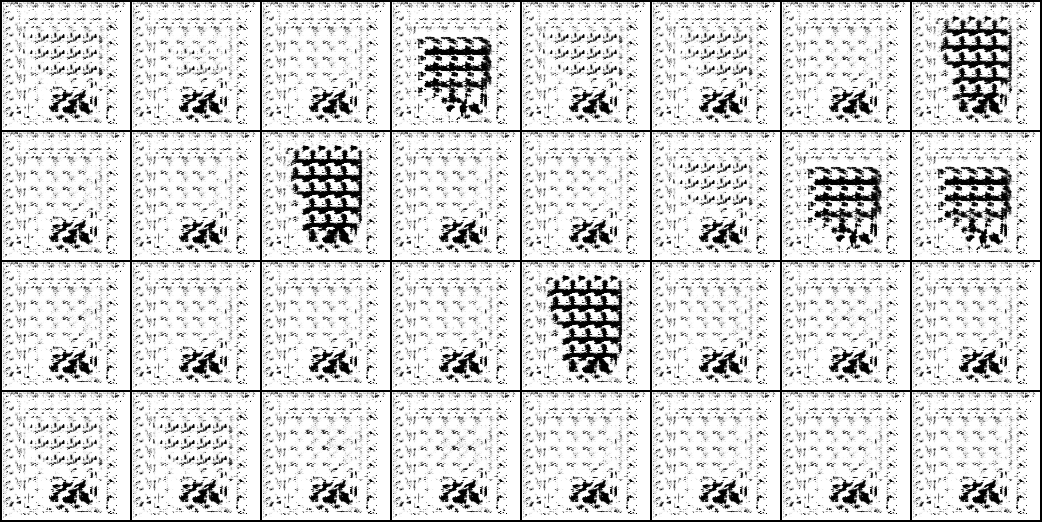

In [2]:
im = Image.open('fixed_fake/fake_samples-60-5000.png')
im

- 59 epoch까지 loss가 문제없이 수렴하다가 60 epoch에서 갑자기 발산해버림.


- 문제 이유를 확실하게는 모르겠으나, 아마 learning rate를 decay 해줘야 하는 거 아닌가 하는 생각


- 50epoch로 저장된 모델에서부터 learning rate 낮춰서 다시 학습시켜보기